In [2]:
import os
import json
import pandas as pd

import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from datasets import get_dataset_config_names

from src.config import Config
from src.preprocess.data import Preprocess

In [3]:
from src.utils import *
setup_chapter()

Using transformers v4.26.1
Using datasets v2.10.1


In [4]:
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
              "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
              "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

In [5]:
domains = get_dataset_config_names("subjqa")
subjqa = load_dataset("subjqa", "electronics")
subjqa.set_format("pandas")

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dfs = {split:ds[:] for split, ds in subjqa.flatten().items()}

for split, df in dfs.items():
    print("Number of questions in {}: {}".format(split, df["id"].nunique()))

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [7]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)

sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [8]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])

sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

<Axes: >

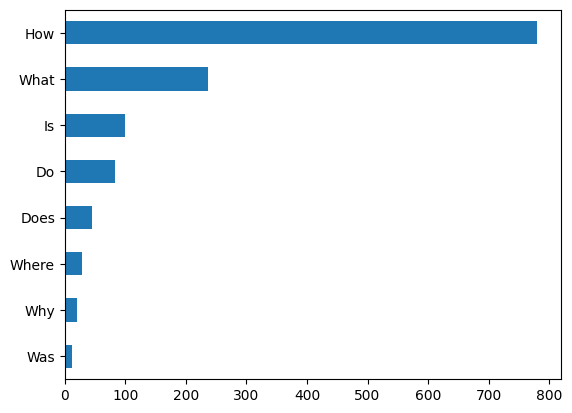

In [9]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
    
pd.Series(counts).sort_values().plot.barh()

### Answers from Text Framework

<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/48e4a5e5c44b86e1593c0945a49af9675cfd7158//images/chapter07_qa-head.png" alt="" width=800 height=400>

- There are over 100 of questions & answering models in huggingface hub
<img src="https://raw.githubusercontent.com/nlp-with-transformers/notebooks/48e4a5e5c44b86e1593c0945a49af9675cfd7158//images/chapter07_squad-models.png" alt="" width=600 height=300>

- 4 models will be tested:
 <table>
  <tr>
    <th>Transformer</th>
    <th>Description</th>
    <th>Number of Parameters</th>
    <th>F1 Score on SQuAD 2.0</th>
  </tr>
  <tr>
    <td>MiniLM</td>
    <td>RoBERTa-base</td>
    <td>ALBERT-XXL</td>
    <td>XLM-RoBERTa-large</td>
  </tr>
  <tr>
    <td>A distilled version of BERT-base that preserved 99% of the performance while being twice a fast</td>
    <td>RoBERTa models have better performance than their BERT counterparts and can be fine-tuned on most QA datasets using a single GPU</td>
    <td>State-of-art performance on SQUaD 2.0, but computationallu intensive and difficult to deploy</td>
    <td>Multilingual model for 100 languages with strong zero-shot performance</td>
  </tr>
  <tr>
    <td>66M</td>
    <td>125M</td>
    <td>235M</td>
    <td>570M</td>
  </tr>
  <tr>
    <td>79.5</td>
    <td>83.0</td>
    <td>88.1</td>
    <td>83.8</td>
  </tr>
</table> 

In [11]:
from transformers import AutoModelForQuestionAnswering,  AutoTokenizer, pipeline

In [13]:
model_name = "deepset/minilm-uncased-squad2"
model_ckpt = AutoModelForQuestionAnswering.from_pretrained(model_name)

OSError: deepest/minilm-uncased-squad2 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)